In [1]:
using QuantumStates
using UnitsToValue

### Load $X(v=0)$ Hamiltonian for $N \in [0,3]$

In [2]:
H0 = load_from_file("CaF_v0_N0to3_Hamiltonian", "G://My Drive//github//QuantumStates//Hamiltonians//CaF//")
;

In [3]:
const μX = 1e-6 * 3.07 * (1e-21 / c) / h;

In [155]:
import QuantumStates: polarizability, Zeeman

# Add AC Stark shifts from trap
w = 25e-6; P = 13.25; I_trap = 2P / (π * w^2);
const α = [3.37471e-39, 0, 1.01809e-39] # 1064 nm
const θ = 0 * (π / 2)
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
polarizability(state, state′) = polarizability(state, state′, α, ϵ_trap)
@time H = add_to_H(H0, :I_trap, (1e-6 / h) * polarizability)

# Add Zeeman terms for a B-fields along x, y, and z
Zeeman_x(state, state′) = (1/√2)  * (Zeeman(state, state′, -1) - Zeeman(state, state′, +1))
Zeeman_y(state, state′) = (im/√2) * (Zeeman(state, state′, -1) + Zeeman(state, state′, +1))
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_x, gS * (μ_B / h) * 1e-10 * Zeeman_x)
H = add_to_H(H, :B_y, gS * (μ_B / h) * 1e-10 * Zeeman_y)
H = add_to_H(H, :B_z, gS * (μ_B / h) * 1e-10 * Zeeman_z)

# Add Stark shift terms
H = add_to_H(H, :E_z, μX * Stark)

# Evaluate and solve the Hamiltonian
H.parameters.I_trap = 0.0
H.parameters.B_z = 0.6
H.parameters.E_z = 30000.
H.parameters.B_x = 0.0
@time full_evaluate!(H)
@time solve!(H)
;

  0.082198 seconds (15.22 k allocations: 1.072 MiB, 22.60% compilation time: 100% of which was recompilation)


  0.178071 seconds (120.11 k allocations: 10.908 MiB, 49.14% compilation time: 100% of which was recompilation)
  0.034906 seconds (744 allocations: 1.273 MiB)


### Zeeman plots for $B_x$ (and $B_z = 10~\text{mG}$)

In [156]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end
;

In [157]:
Bs = (0:0.1:1)
scan_params = (
    B = Bs,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.588522 seconds (185.69 k allocations: 47.255 MiB, 25.21% compilation time)


In [221]:
using Plots, LaTeXStrings
plot(Bs, matrix_values[:,12:16], linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="B (G)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

LoadError: Expects 11 elements in each col of y, found 101.

In [159]:
H.states[16]

State{HundsCaseB_Rot}(20658.12899325812, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:∞

In [160]:
H.states[15]

State{HundsCaseB_Rot}(20658.126957631444, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [161]:
H.states[14]

State{HundsCaseB_Rot}(20657.212560150903, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [162]:
H.states[13]

State{HundsCaseB_Rot}(20656.84794615113, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:∞

In [163]:
TDM(H.states[16], H.states[15], -1)

-0.001592382310211147 + 0.0im

# Scan AC Stark shift

In [222]:
H.parameters.B_z = 0.0
H.parameters.E_z = 20000.0
H.parameters.I_trap = I_trap / (2ε_0 * c)
full_evaluate!(H)
solve!(H)
;

In [223]:
function H_func!(H, scan_values)
    H.parameters.I_trap = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end
;

In [224]:
Is = (0:0.01:1.0) .* I_trap / (2ε_0 * c)
scan_params = (
    I = Is,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03Progress:  38%|████████████████                         |  ETA: 0:00:02


  3.881803 seconds (260.19 k allocations: 162.830 MiB, 7.26% compilation time)


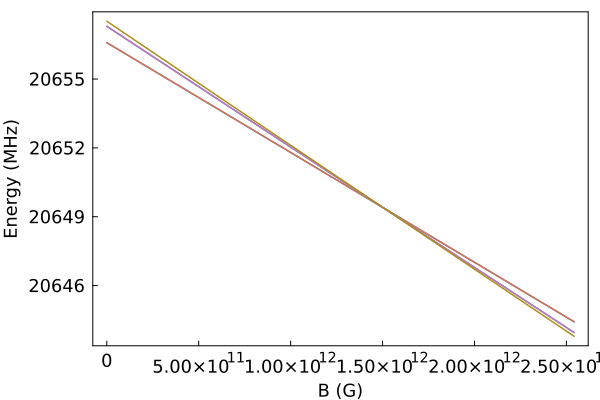

In [225]:
using Plots, LaTeXStrings
plot(Is, matrix_values[:,12:16], linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="B (G)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

In [226]:
H.states[16]

State{HundsCaseB_Rot}(20644.420046835417, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [227]:
H.states[15]

State{HundsCaseB_Rot}(20644.420046835356, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [205]:
H.states[14]

State{HundsCaseB_Rot}(20643.951816637775, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [206]:
H.states[13]

State{HundsCaseB_Rot}(20643.95181663777, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:∞

In [207]:
H.states[12]

State{HundsCaseB_Rot}(20643.786943533407, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:

In [220]:
TDM(H.states[12], H.states[14])

-0.0012615456880868134 + 0.00055552962668312im

# Look at spin-rotation states

In [275]:
H.parameters.B_z = 0.0
H.parameters.E_z = 0.0
H.parameters.I_trap = 0.0
H.parameters.bX = 0.0
H.parameters.cX = 0.0
H.parameters.γX = 40.
full_evaluate!(H)
solve!(H)
;

In [276]:
H.states[2]

State{HundsCaseB_Rot}(30.639225, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:∞, J = 0.

In [277]:
H.states[5]

State{HundsCaseB_Rot}(20508.7187775605, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0:∞,

In [278]:
H.states[10]

State{HundsCaseB_Rot}(20625.842292439494, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N = 0: